In [158]:
#подключаем библиотеки
import pandas as pd
import pandahouse as ph
import numpy as np
from scipy import stats
import seaborn as sns
from tqdm import tqdm
%matplotlib inline

import orbit
from orbit.models import DLT
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.diagnostics.backtest import BackTester
from orbit.utils.params_tuning import grid_search_orbit
from orbit.diagnostics.metrics import rmsse
from orbit.diagnostics.metrics import smape

In [129]:
#настройки графиков
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(15,6)}
        )

In [130]:
#подключаемся к кликхаусу
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20240720'
}

q = """
select toStartOfInterval(time, INTERVAL 1 hour) as hour_time,
        count(user_id)  as actions,
        count(distinct user_id) as users        
from {db}.feed_actions
where toDate(time) <= '2024-08-10'
group by hour_time
order by hour_time
"""

# Вытащили пользователей
df = ph.read_clickhouse(q, connection=connection)
df = df.astype({"users":"int64"})

In [131]:
df.head()

,hour_time,actions,users
0,2024-06-01 00:00:00,22,14
1,2024-06-01 01:00:00,32,26
2,2024-06-01 02:00:00,24,16
3,2024-06-01 03:00:00,11,11
4,2024-06-01 04:00:00,18,14


Для прогнозирования выбрал количество событий в час в качестве основной метрики, т.к. она хорошо показывает активность пользователей.
В качестве регрессора будет количество уникальных пользователей.

In [142]:
#довольно сильная корреляция
df[['actions','users']].corr()

,actions,users
actions,1.000000,0.822989
users,0.822989,1.000000


<Axes: xlabel='hour_time', ylabel='actions'>

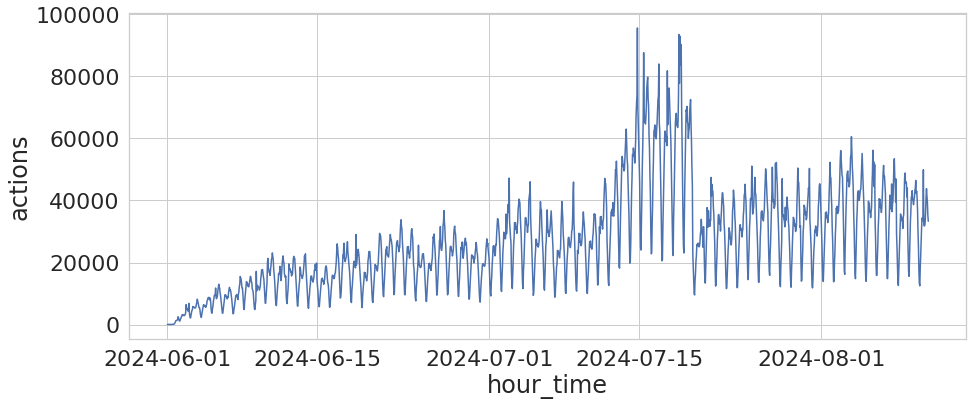

In [132]:
#посмотрим динамику нашей метрики во времени
sns.lineplot(df, x = 'hour_time', y = 'actions')

In [133]:
#разделим нашу выборку на обучающую и тестовую, в тестовую положим последние 2 недели
train_df = df.query("hour_time < '2024-07-30 00:00:00'")
test_df = df.query("hour_time >= '2024-07-30 00:00:00'").astype({"users":"int64"})

In [179]:
#обучим модель без регрессора
no_reg_model = DLT(response_col="actions",
                date_col="hour_time", 
                seasonality=24,
                estimator="stan-map", 
                n_bootstrap_draws=1000
               )

no_reg_model.fit(train_df)

2024-08-12 14:27:45 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.


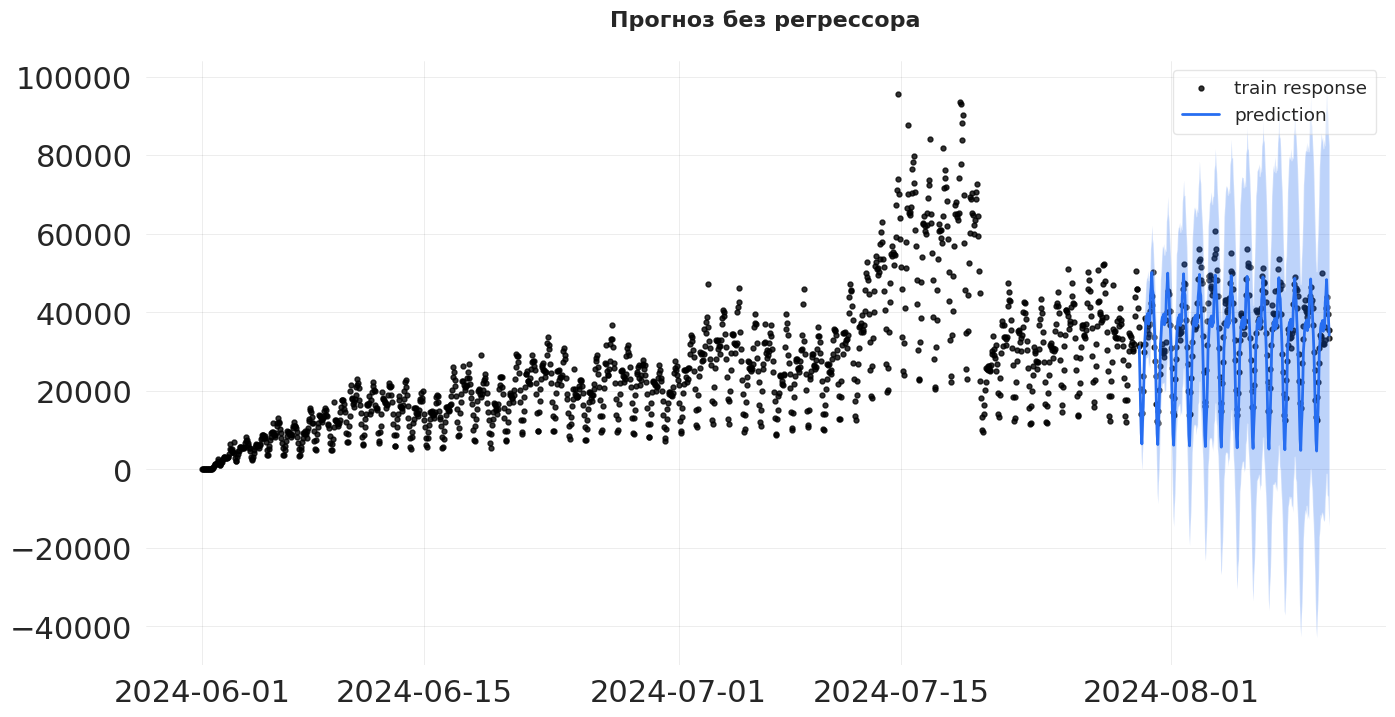

In [180]:
#предиктим
predicted_df_no_reg = no_reg_model.predict(df=test_df)
_ = plot_predicted_data(df, predicted_df_no_reg, "hour_time", 'actions', title='Прогноз без регрессора') #очень широкие доверительные интервалы

In [181]:
#обучим модель с регрессором users
reg_model = DLT(response_col="actions",
                date_col="hour_time", 
                seasonality=24,
                estimator="stan-map", 
                n_bootstrap_draws=1000, 
                regressor_col=["users"]
               )
reg_model.fit(train_df)

2024-08-12 14:28:07 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.


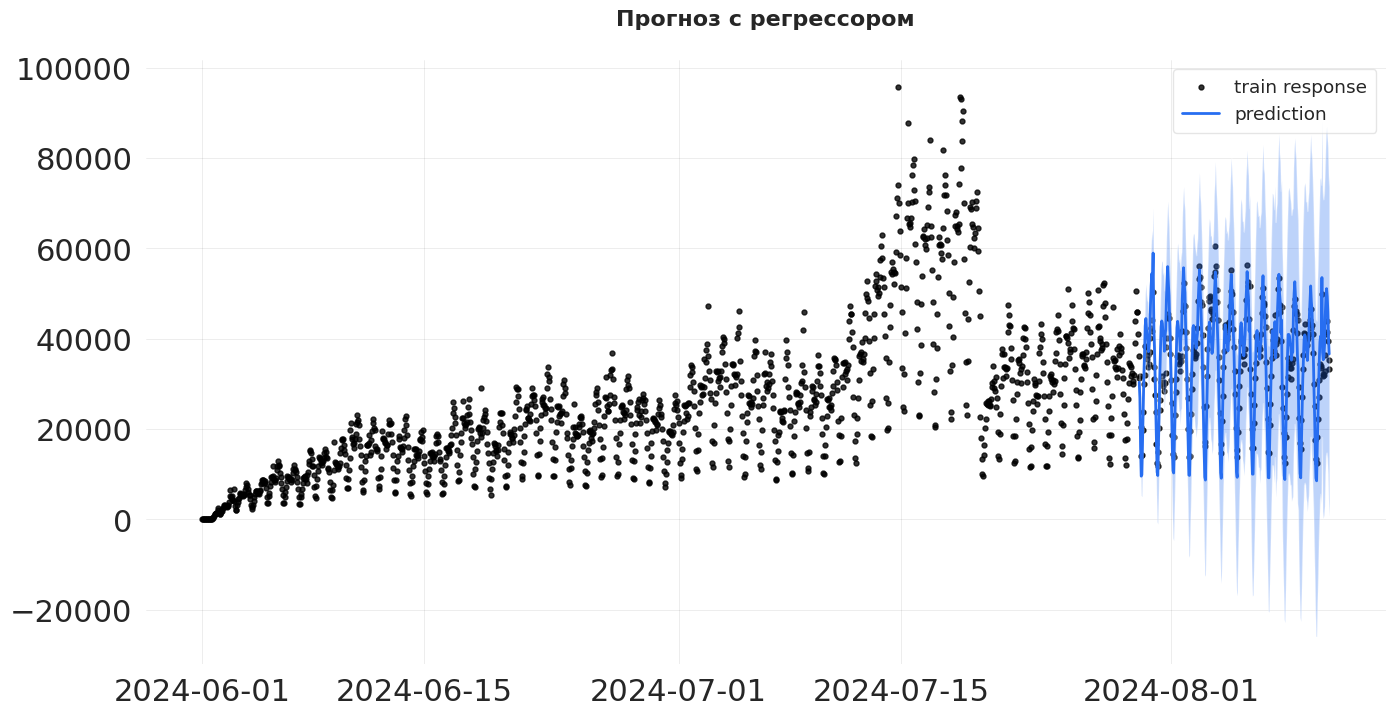

In [182]:
#предиктим
predicted_df_reg = reg_model.predict(df=test_df)
_ = plot_predicted_data(df, predicted_df_reg, "hour_time", 'actions', title='Прогноз с регрессором') #уже получше

In [183]:
#добавим априорного распределения, поскольку мы знаем как влияет регрессор на метрику
reg_model_prior = DLT(response_col="actions",
                date_col="hour_time", 
                seasonality=24,
                estimator="stan-map", 
                n_bootstrap_draws=1000, 
                regressor_col=["users"], 
                regressor_sign=["+"], #чем больше пользователей, тем больше событий
                regressor_beta_prior=[0.6], #предполагаем что коэфф 0.3
                regressor_sigma_prior=[0.1] #уровень уверенности
               ) 

reg_model_prior.fit(train_df)

2024-08-12 14:28:29 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.


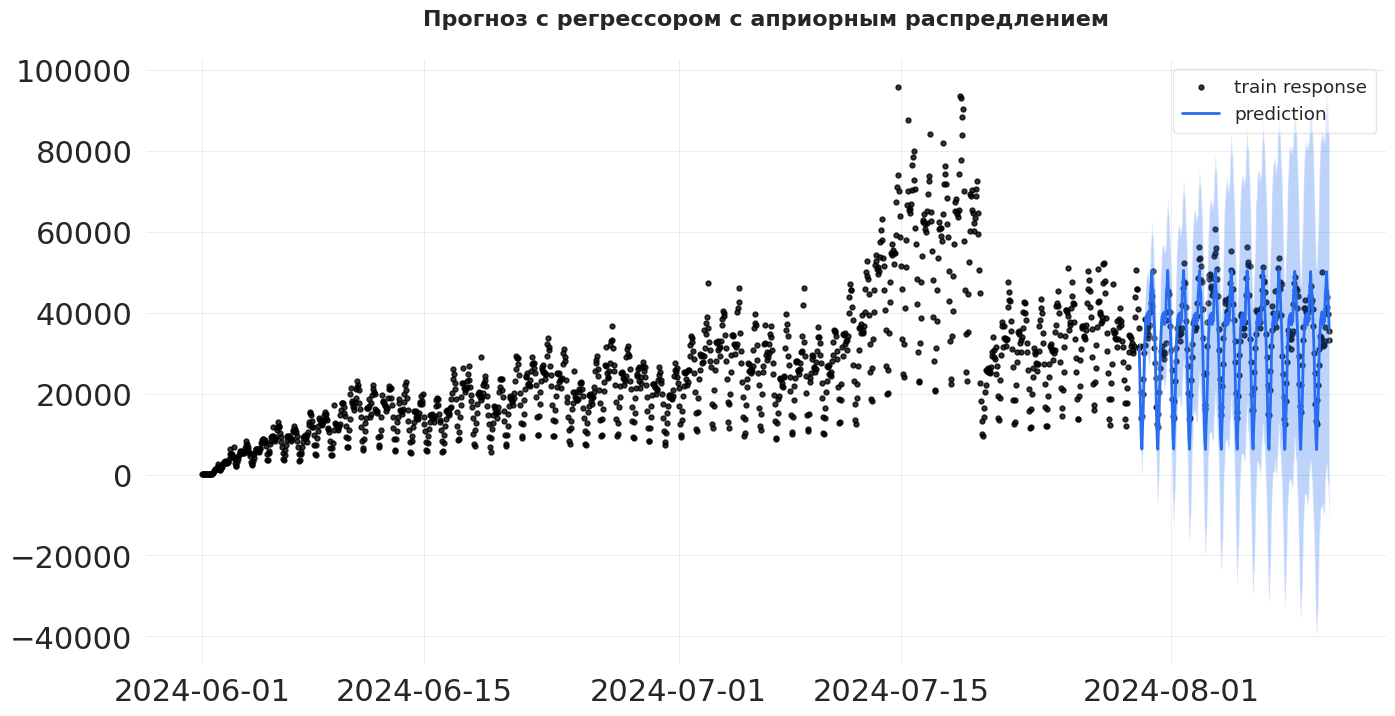

In [184]:
#предиктим
predicted_df_prior = reg_model_prior.predict(df=test_df)
_ = plot_predicted_data(df, predicted_df_prior, "hour_time", 'actions', title='Прогноз с регрессором с априорным распредлением') #довольно широкие доверительтные интервалы

In [185]:
#добавим регуляризацию auto_ridge
reg_model_auto = DLT(response_col="actions",
                date_col="hour_time", 
                seasonality=24,
                estimator="stan-map", 
                n_bootstrap_draws=1000, 
                regressor_col=["users"], 
                regression_penalty="auto_ridge"
               ) 

reg_model_auto.fit(train_df)

2024-08-12 14:28:47 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.


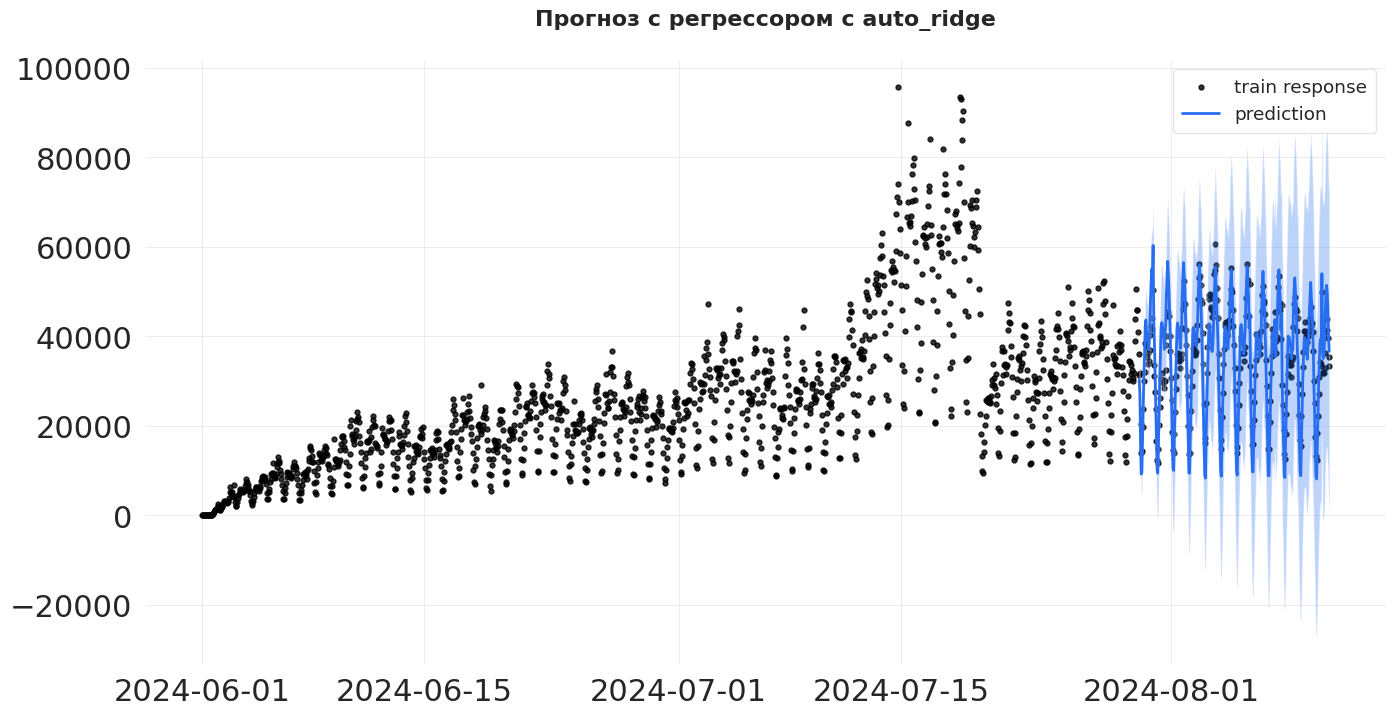

In [186]:
#предиктим
predicted_df_auto = reg_model_auto.predict(df=test_df)
_ = plot_predicted_data(df, predicted_df_auto, "hour_time", 'actions', title='Прогноз с регрессором с auto_ridge') #получилось довольно хорошо "на глаз"

In [187]:
#попробуем через lasso
reg_model_lasso = DLT(response_col="actions",
                date_col="hour_time", 
                seasonality=24,
                estimator="stan-map", 
                n_bootstrap_draws=1000, 
                regressor_col=["users"], 
                regression_penalty="lasso"
               ) 

reg_model_lasso.fit(train_df)

2024-08-12 14:29:06 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.


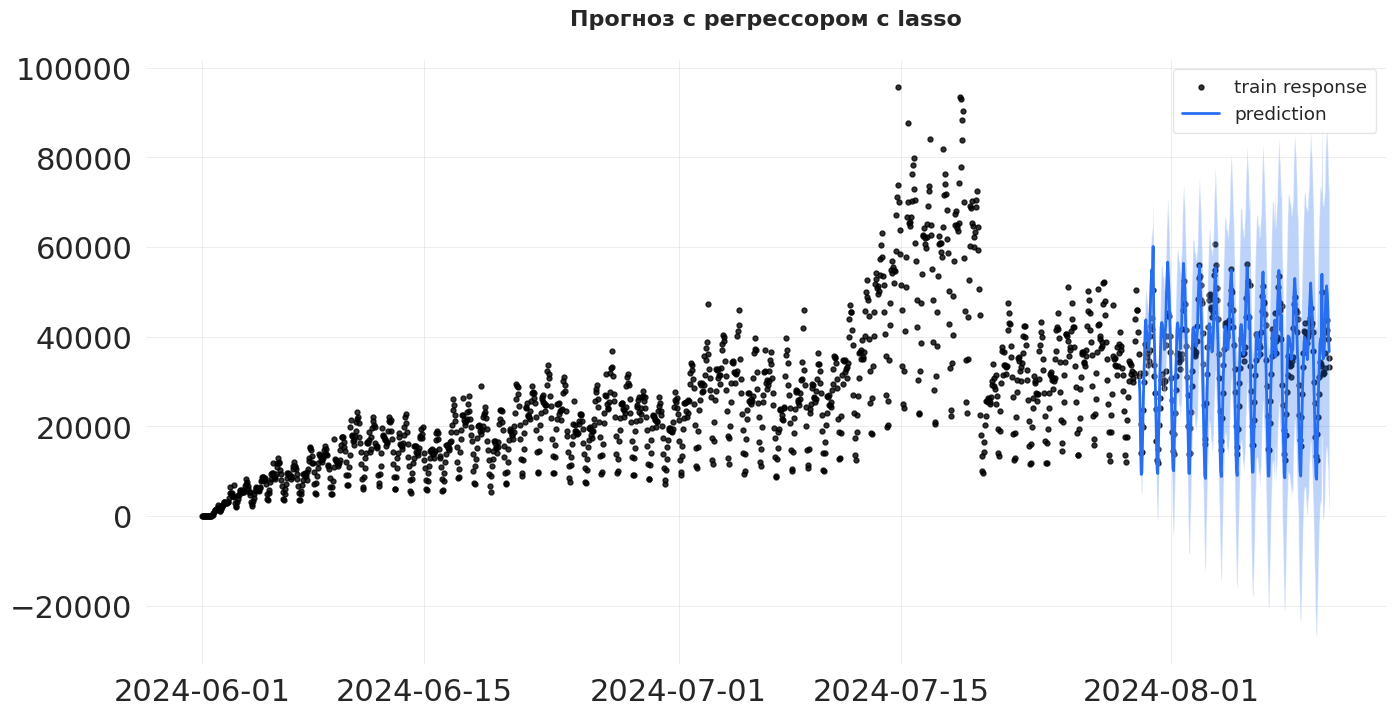

In [188]:
#предиктим
predicted_df_lasso = reg_model_lasso.predict(df=test_df)
_ = plot_predicted_data(df, predicted_df_lasso, "hour_time", 'actions', title='Прогноз с регрессором с lasso') #кажется чуть хуже чем auto_ridge

In [190]:
#сравним модели через информационный критерий
print(f"Без регрессора: {no_reg_model.get_bic()}")
print(f"С регрессором: {reg_model.get_bic()}")
print(f"С информативным распределением: {reg_model_prior.get_bic()}")
print(f"С auto-ridge: {reg_model_auto.get_bic()}")
print(f"С lasso: {reg_model_lasso.get_bic()}")

Без регрессора: 26278.808417720928
С регрессором: 24918.555282531004
С информативным распределением: 26212.715302531004
С auto-ridge: 24893.504502531003
С lasso: 24893.932442531004


In [191]:
#сравним модели по rmsse
print(f"Без регрессора: {rmsse(test_df.actions.values, predicted_df_no_reg.prediction.values, train_df.actions.values)}")
print(f"С регрессором: {rmsse(test_df.actions.values, predicted_df_reg.prediction.values, train_df.actions.values)}")
print(f"С априорным распределением: {rmsse(test_df.actions.values, predicted_df_prior.prediction.values, train_df.actions.values)}")
print(f"С auto-ridge: {rmsse(test_df.actions.values, predicted_df_auto.prediction.values, train_df.actions.values)}")
print(f"С lasso: {rmsse(test_df.actions.values, predicted_df_lasso.prediction.values, train_df.actions.values)}")

Без регрессора: 1.300748978166782
С регрессором: 1.0103414404041329
С априорным распределением: 1.1938074269511698
С auto-ridge: 1.0170864786051694
С lasso: 1.014656527106466


In [192]:
#сравним модели по smape
print(f"Без регрессора: {smape(test_df.actions.values, predicted_df_no_reg.prediction.values)}")
print(f"С регрессором: {smape(test_df.actions.values, predicted_df_reg.prediction.values)}")
print(f"С априорным распределением: {smape(test_df.actions.values, predicted_df_prior.prediction.values)}")
print(f"С auto-ridge: {smape(test_df.actions.values, predicted_df_auto.prediction.values)}")
print(f"С lasso: {smape(test_df.actions.values, predicted_df_lasso.prediction.values)}")

Без регрессора: 0.21394522480375874
С регрессором: 0.13699717462717706
С априорным распределением: 0.19134463406123814
С auto-ridge: 0.14025672541585912
С lasso: 0.13963619731699364


По метрикам качества выигрывает обычная модель с регрессором, модель с auto_ridge и модель с lasso. Сравним их далее более детально.

In [213]:
#проверим наши 3 модели через бэктетинг

bt_exp = BackTester(
    model=reg_model, #наша моделька
    df=df, #датафрейм для обучения
    min_train_len=24*14, #самый маленький кусочек данных, с которого начинается обучение
    incremental_len=24, #на сколько происходит прирост тренировочных данных
    forecast_len=24*30, #горизонт пронозирования
    window_type="expanding" #тип окошка
)

bt_exp_auto = BackTester(
    model=reg_model_auto, #наша моделька
    df=df, #датафрейм для обучения
    min_train_len=24*14, #самый маленький кусочек данных, с которого начинается обучение
    incremental_len=24, #на сколько происходит прирост тренировочных данных
    forecast_len=24*30, #горизонт пронозирования
    window_type="expanding" #тип окошка
)

bt_exp_lasso = BackTester(
    model=reg_model_lasso, #наша моделька
    df=df, #датафрейм для обучения
    min_train_len=24*14, #самый маленький кусочек данных, с которого начинается обучение
    incremental_len=24, #на сколько происходит прирост тренировочных данных
    forecast_len=24*30, #горизонт пронозирования
    window_type="expanding" #тип окошка
)

In [199]:
bt_exp.fit_predict() #обучаем

In [200]:
bt_exp.score() #выводим метрики

,metric_name,metric_values,is_training_metric
0,smape,4.112791e-01,False
1,wmape,3.452639e-01,False
2,mape,3.103981e-01,False
3,mse,2.858641e+08,False
4,mae,1.155184e+04,False
5,rmsse,3.326279e+00,False


In [209]:
bt_exp_auto.fit_predict() #обучаем

In [210]:
bt_exp_auto.score() #выводим метрики

,metric_name,metric_values,is_training_metric
0,smape,4.889226e-01,False
1,wmape,3.824667e-01,False
2,mape,3.628578e-01,False
3,mse,3.548659e+08,False
4,mae,1.279657e+04,False
5,rmsse,3.706048e+00,False


In [206]:
bt_exp_lasso.fit_predict() #обучаем

In [207]:
bt_exp_lasso.score() #выводим метрики

,metric_name,metric_values,is_training_metric
0,smape,7.101664e-01,False
1,wmape,5.025485e-01,False
2,mape,4.924041e-01,False
3,mse,5.099926e+08,False
4,mae,1.681427e+04,False
5,rmsse,4.442842e+00,False


Для проверки бэктестером данных хватило и судя по метрикам smape и rmsse я бы выбрал обычную модель с регрессором